In [1]:
!pip install stanza==1.4.2
!pip install pandas==1.1.0
!pip install statsmodels==0.13.2

In [2]:
import json
import math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as patches

from textwrap import wrap
from statsmodels.stats.inter_rater import fleiss_kappa

from scipy.stats import kendalltau, mode
from correlation import goodman_kruskal_gamma, goodman_kruskal_concordance

import stanza

In [3]:
LANG = 'sv'
MODE = 'test'

In [4]:
tokenizer = stanza.Pipeline(lang=LANG, processors='tokenize,mwt,pos' if LANG == 'fi' else 'tokenize,pos')

2022-10-29 14:22:38 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2022-10-29 14:22:38 INFO: Loading these models for language: sv (Swedish):
| Processor | Package   |
-------------------------
| tokenize  | talbanken |
| pos       | talbanken |

2022-10-29 14:22:38 INFO: Use device: cpu
2022-10-29 14:22:38 INFO: Loading: tokenize
2022-10-29 14:22:38 INFO: Loading: pos
2022-10-29 14:22:38 INFO: Done loading processors!


In [5]:
d = json.load(open('{}_{}.json'.format(LANG, MODE), encoding='utf-8-sig'))

In [6]:
answer_groups = ["\n".join(wrap(x['answer_group'], 30)) for x in list(d['responses'][0]['responses'].values())[0]]
ideal = {x: y for x, y in zip(answer_groups, [4, 4, 1, 1, 4, 4, 1, 1, 1])}
gold_sentences = [k for k, v in d['responses'][0]['responses'].items() if v[0]['extra']['model'] == 'gold']
gen_sentences = [k for k, v in d['responses'][0]['responses'].items() if v[0]['extra']['model'] == 'gen']
print(answer_groups)

['Frågan är grammatiskt korrekt.', 'Frågan är begriplig.', 'Frågan vore klarare om den\ninnehöll mer information.', 'Frågan vore klarare om den\ninnehöll mindre information.', 'Frågan är relevant för den\ngivna meningen.', 'Det föreslagna svaret besvarar\nfrågan korrekt.', 'Det föreslagna svaret vore\nklarare om det hade uttryckts\npå ett annat sätt.', 'Det föreslagna svaret vore\nklarare om den innehöll mer\ninformation.', 'Det föreslagna svaret vore\nklarare om den innehöll mindre\ninformation.']


In [7]:
assert len(gold_sentences) == len(gen_sentences), "something is wrong with the data"
total_triples = len(gold_sentences)

The questions are generated from exactly the same sentences, so sentence length distribution is irrelevant.

In [8]:
gold_q_lengths = np.array([len([w for s in tokenizer(gs.split('<br>')[1].replace('Question: ', '')).sentences
                       for w in s.tokens]) for gs in gold_sentences])

<AxesSubplot: ylabel='Count'>

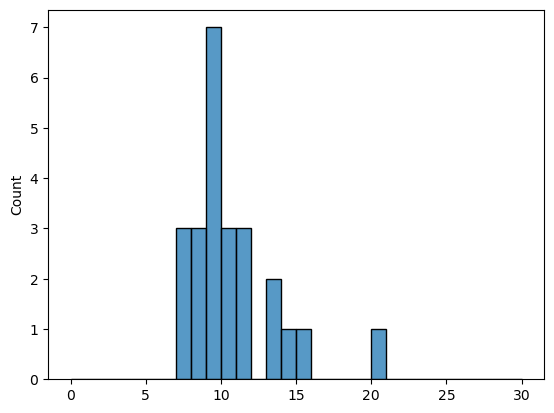

In [9]:
sns.histplot(gold_q_lengths, binrange=(0,30), binwidth=1)

In [10]:
gen_q_lengths = np.array([len([w for s in tokenizer(gs.split('<br>')[1].replace('Question: ', '')).sentences
                       for w in s.tokens]) for gs in gen_sentences])

<AxesSubplot: ylabel='Count'>

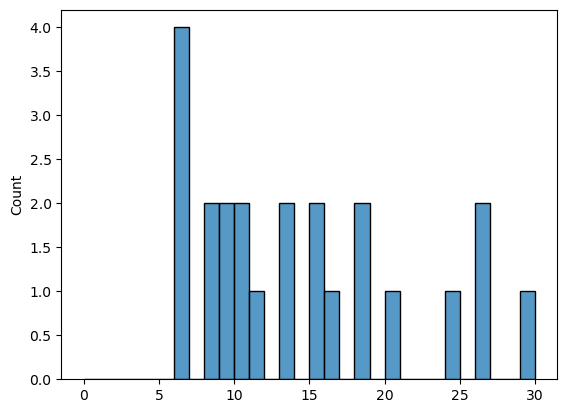

In [11]:
sns.histplot(gen_q_lengths, binrange=(0,30), binwidth=1)

In [12]:
gold = [pd.DataFrame.from_dict({
    k: [x['value'] for x in v] 
    for k, v in r['responses'].items() if v[0]['extra']['model'] == 'gold'
}, orient='index', columns=answer_groups) for r in d['responses']]

In [13]:
gen = [pd.DataFrame.from_dict({
    k: [x['value'] for x in v] 
    for k, v in r['responses'].items() if v[0]['extra']['model'] == 'gen'
}, orient='index', columns=answer_groups) for r in d['responses']]

In [14]:
def calc_multirater_gamma(arr):
    U = len(arr)
    gamma = []
    for ag in answer_groups:
        C, D = 0, 0
        for i in range(U):
            for j in range(i+1,U):
                c, d, t = goodman_kruskal_concordance(
                    arr[i].loc[:,ag].sort_index(),
                    arr[j].loc[:,ag].sort_index()
                )
                C += c
                D += d
        N = arr[i].shape[0]
        if C > 0 or D > 0:
            G = (C - D) / (C + D)
            gamma.append([ag.replace('\n', ' '), G, G * np.sqrt((C + D) / (U * N * (1 - ((G)**2-1e-15))))])
        else:
            gamma.append([ag.replace('\n', ' '), 'NA', 'absolutely equal judgements'])
    return pd.DataFrame(gamma, columns=['criterion', 'multi-gamma', 'z'])

In [15]:
calc_multirater_gamma(gold)

,criterion,multi-gamma,z
0,Frågan är grammatiskt korrekt.,0.913043,1.54961
1,Frågan är begriplig.,NA,absolutely equal judgements
2,Frågan vore klarare om den innehöll mer inform...,NA,absolutely equal judgements
3,Frågan vore klarare om den innehöll mindre inf...,NA,absolutely equal judgements
4,Frågan är relevant för den givna meningen.,NA,absolutely equal judgements
5,Det föreslagna svaret besvarar frågan korrekt.,-1,-1.02103e+07
6,Det föreslagna svaret vore klarare om det hade...,NA,absolutely equal judgements
7,Det föreslagna svaret vore klarare om den inne...,NA,absolutely equal judgements
8,Det föreslagna svaret vore klarare om den inne...,NA,absolutely equal judgements


In [16]:
calc_multirater_gamma(gen)

,criterion,multi-gamma,z
0,Frågan är grammatiskt korrekt.,0.546218,1.02674
1,Frågan är begriplig.,0.753247,2.05128
2,Frågan vore klarare om den innehöll mer inform...,-0.0869565,-0.0854493
3,Frågan vore klarare om den innehöll mindre inf...,1,2.04206e+07
4,Frågan är relevant för den givna meningen.,0.809524,2.41304
5,Det föreslagna svaret besvarar frågan korrekt.,0.783333,1.99253
6,Det föreslagna svaret vore klarare om det hade...,1,2.81478e+07
7,Det föreslagna svaret vore klarare om den inne...,0.932203,2.85552
8,Det föreslagna svaret vore klarare om den inne...,NA,absolutely equal judgements


In [17]:
def calc_gkgamma(arr, answer_group):
    N = len(arr)
    corr, ties = np.zeros(shape=(N, N)), np.zeros(shape=(N, N))
    for i in range(N):
        for j in range(i, N):
            res = goodman_kruskal_gamma(arr[i].loc[:,answer_group].sort_index().to_numpy(),
                                        arr[j].loc[:,answer_group].sort_index().to_numpy())
            corr[i][j] = res['correlation']
            ties[i][j] = res['ties']
    return pd.DataFrame(corr), pd.DataFrame(ties)

In [18]:
corr, ties = calc_gkgamma(gold, answer_groups[0])
corr

,0,1
0,1.0,0.913043
1,0.0,1.000000


In [19]:
def plot_per_participant(arr):
    for i in range(len(arr)):
        dfm = arr[i].melt(var_name='statement')
        g = sns.FacetGrid(dfm, col='statement', col_wrap=3)
        g = (g.map(sns.histplot, 'value', binrange=(0.25, 4.25), binwidth=0.5))
        g.set_titles(row_template='{row_name}', col_template='{col_name}')
        plt.savefig('gen_annotator_{}.pdf'.format(i))

Marginals are considered to be fixed when raters know a priori the quantity of cases that should be distributed into each category.

Marginal distributions are considered to be free when raters do not know a priori the quantities of cases that should be distributed into each category.

Multirater (Randolph) κ is appropriate when one or more marginals are not fixed.

In [20]:
def calc_randolph_kappa(arr, min_rank=0, max_rank=5):
    fleiss = []
    for j in range(len(answer_groups)):
        user_ratings = pd.concat([arr[i].loc[:,answer_groups[j]].sort_index()
            for i in range(len(arr))], axis=1).apply(lambda x: x.value_counts(), axis=1).fillna(0)
        for rr in range(min_rank, max_rank+1):
            try:
                user_ratings.loc[:,rr]
            except KeyError:
                user_ratings.loc[:,rr] = 0
        user_ratings = user_ratings.sort_index(axis=1)
        fleiss.append((answer_groups[j].replace('\n', ' '), fleiss_kappa(user_ratings, 'rand')))
    return pd.DataFrame(fleiss, columns=['criterion', 'randolph kappa'])

In [21]:
gold_kappa = calc_randolph_kappa(gold, 1, 4)
gold_kappa

,criterion,randolph kappa
0,Frågan är grammatiskt korrekt.,0.833333
1,Frågan är begriplig.,0.888889
2,Frågan vore klarare om den innehöll mer inform...,0.833333
3,Frågan vore klarare om den innehöll mindre inf...,1.000000
4,Frågan är relevant för den givna meningen.,0.666667
5,Det föreslagna svaret besvarar frågan korrekt.,0.666667
6,Det föreslagna svaret vore klarare om det hade...,0.944444
7,Det föreslagna svaret vore klarare om den inne...,0.944444
8,Det föreslagna svaret vore klarare om den inne...,1.000000


In [22]:
gen_kappa = calc_randolph_kappa(gen, 1, 4)
gen_kappa

,criterion,randolph kappa
0,Frågan är grammatiskt korrekt.,0.333333
1,Frågan är begriplig.,0.388889
2,Frågan vore klarare om den innehöll mer inform...,0.166667
3,Frågan vore klarare om den innehöll mindre inf...,0.833333
4,Frågan är relevant för den givna meningen.,0.444444
5,Det föreslagna svaret besvarar frågan korrekt.,0.555556
6,Det föreslagna svaret vore klarare om det hade...,0.833333
7,Det föreslagna svaret vore klarare om den inne...,0.833333
8,Det föreslagna svaret vore klarare om den inne...,1.000000


In [23]:
def get_median_df(arr, melt=True):
    df_concat = pd.concat(arr).melt(ignore_index=False)
    df_agg = df_concat.groupby([df_concat.index, 'variable']).agg('median')
    df_agg = df_agg.unstack('variable')
    df_agg.columns = df_agg.columns.droplevel(0)
    df_agg.columns.name = 'median'
    if melt:
        df_agg = df_agg.reindex(columns=answer_groups).melt(ignore_index=False)
        df_agg.columns = ['criterion', 'median']
    return df_agg

In [24]:
base_gold_df = get_median_df(gold, melt=False)
base_gold_melted_df = get_median_df(gold)
base_gen_df = get_median_df(gen, melt=False)
base_gen_melted_df = get_median_df(gen)

In [25]:
# grammaticality
print("Gold -- {}".format(answer_groups[0]))
df = base_gold_melted_df.copy()
df = df[df['criterion'] == answer_groups[0]]
N_g_gold = len(df[df['median'] >= 3])
print(N_g_gold)
print()

print("Gen -- {}".format(answer_groups[0]))
df = base_gen_melted_df.copy()
df = df[df['criterion'] == answer_groups[0]]
N_g_gen = len(df[df['median'] >= 3])
print(N_g_gen)

Gold -- Frågan är grammatiskt korrekt.
23

Gen -- Frågan är grammatiskt korrekt.
10


In [26]:
# makes sense
print("Gold -- {}".format(answer_groups[1]))
df = base_gold_melted_df.copy()
df = df[df['criterion'] == answer_groups[1]]
N_s_gold = len(df[df['median'] >= 3])
print(N_s_gold)
print()

print("Gen -- {}".format(answer_groups[1]))
df = base_gen_melted_df.copy()
df = df[df['criterion'] == answer_groups[1]]
N_s_gen = len(df[df['median'] >= 3])
print(N_s_gen)

Gold -- Frågan är begriplig.
23

Gen -- Frågan är begriplig.
8


In [27]:
# grammatical and makes sense
print('Gold -- "{}" och "{}"'.format(answer_groups[0], answer_groups[1]))
df = base_gold_df.copy()
gns_df = df[(df.loc[:,answer_groups[0]] >= 3) & (df.loc[:,answer_groups[1]] >= 3)]
N_gns_gold = len(gns_df)
print(N_gns_gold)
print()

print('Gen --"{}" och "{}"'.format(answer_groups[0], answer_groups[1]))
df = base_gen_df.copy()
gns_df = df[(df.loc[:,answer_groups[0]] >= 3) & (df.loc[:,answer_groups[1]] >= 3)]
N_gns_gen = len(gns_df)
print(N_gns_gen)

Gold -- "Frågan är grammatiskt korrekt." och "Frågan är begriplig."
23

Gen --"Frågan är grammatiskt korrekt." och "Frågan är begriplig."
7


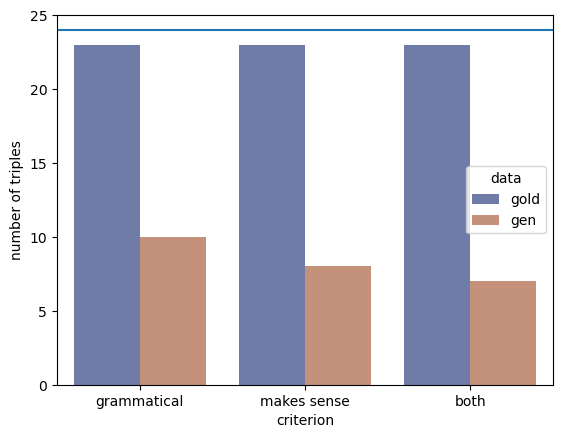

In [28]:
df = pd.DataFrame.from_dict({
    'criterion': ['grammatical', 'grammatical', 'makes sense', 'makes sense', 'both', 'both'],
    'data': ['gold', 'gen', 'gold', 'gen', 'gold', 'gen'],
    'number of triples': [N_g_gold, N_g_gen, N_s_gold, N_s_gen, N_gns_gold, N_gns_gen]
})
graph = sns.barplot(data=df, x='criterion', y='number of triples', hue='data', palette="dark", alpha=.6)
graph.axhline(total_triples)
plt.ylim(0, math.ceil(total_triples / 5) * 5)
plt.savefig("{}_gns.pdf".format(MODE), bbox_inches='tight')

In [29]:
# gold not making sense
df = base_gold_df.copy()
odd_df = df[(df.loc[:,answer_groups[1]] < 3)]
odd_df

median,Det föreslagna svaret besvarar\nfrågan korrekt.,Det föreslagna svaret vore\nklarare om den innehöll mer\ninformation.,Det föreslagna svaret vore\nklarare om den innehöll mindre\ninformation.,Det föreslagna svaret vore\nklarare om det hade uttryckts\npå ett annat sätt.,Frågan vore klarare om den\ninnehöll mer information.,Frågan vore klarare om den\ninnehöll mindre information.,Frågan är begriplig.,Frågan är grammatiskt korrekt.,Frågan är relevant för den\ngivna meningen.
"Meningen: maskinförare har oregelbundna arbetstider, arbetet styrs mycket av vädret.<br>Frågan: vad styr maskinförares arbetstider mycket av?<br>Det föreslagna svaret: av vädret",4.0,1.0,1.0,1.0,1.0,1.0,2.5,2.0,4.0


In [30]:
# makes sense, but not grammatical
df = base_gen_df.copy()
odd_df = df[(df.loc[:,answer_groups[0]] < 3) & (df.loc[:,answer_groups[1]] >= 3)]
odd_df

median,Det föreslagna svaret besvarar\nfrågan korrekt.,Det föreslagna svaret vore\nklarare om den innehöll mer\ninformation.,Det föreslagna svaret vore\nklarare om den innehöll mindre\ninformation.,Det föreslagna svaret vore\nklarare om det hade uttryckts\npå ett annat sätt.,Frågan vore klarare om den\ninnehöll mer information.,Frågan vore klarare om den\ninnehöll mindre information.,Frågan är begriplig.,Frågan är grammatiskt korrekt.,Frågan är relevant för den\ngivna meningen.
Meningen: processoperatörer inom pappersindustrin kontrollerar de olika stegen i tillverkningen från massa till färdigt papper.<br>Frågan: vilka kontrollerar de olika stegen till färdigt papper?<br>Det föreslagna svaret: processoperatörer,4.0,1.0,1.0,1.0,2.5,1.0,3.0,2.5,4.0


In [31]:
# Grammatical, make sense and relevant
print('Gen --"{}" and "{}" and "{}"'.format(answer_groups[0], answer_groups[1], answer_groups[4]))
df = base_gen_df.copy()
gsr_df = df[(df.loc[:,answer_groups[0]] >= 3) & (df.loc[:,answer_groups[1]] >= 3) & (df.loc[:,answer_groups[4]] >= 3)]
N_gsr_gen = len(gsr_df)
print(N_gsr_gen)

Gen --"Frågan är grammatiskt korrekt." and "Frågan är begriplig." and "Frågan är relevant för den
givna meningen."
6


In [32]:
# Grammatical, make sense and suitable CA
print('Gen --"{}" and "{}" and "{}"'.format(answer_groups[0], answer_groups[1], answer_groups[5]))
df = base_gen_df.copy()
gsa_df = df[(df.loc[:,answer_groups[0]] >= 3) & (df.loc[:,answer_groups[1]] >= 3) & (df.loc[:,answer_groups[5]] >= 3)]
N_gsa_gen = len(gsa_df)
print(N_gsa_gen)

Gen --"Frågan är grammatiskt korrekt." and "Frågan är begriplig." and "Det föreslagna svaret besvarar
frågan korrekt."
5


In [33]:
# Grammatical, make sense, relevant and suitable CA
print('Gen --"{}" and "{}" and "{}" and "{}'.format(answer_groups[0], answer_groups[1], answer_groups[4], answer_groups[5]))
df = base_gen_df.copy()
ultimate_df = df[(df.loc[:,answer_groups[0]] >= 3) & (df.loc[:,answer_groups[1]] >= 3) & (df.loc[:,answer_groups[4]] >= 3) & (df.loc[:,answer_groups[5]] >= 3)]
N_ultimate_gen = len(ultimate_df)
print(N_ultimate_gen)

Gen --"Frågan är grammatiskt korrekt." and "Frågan är begriplig." and "Frågan är relevant för den
givna meningen." and "Det föreslagna svaret besvarar
frågan korrekt.
5


In [48]:
# Making no sense
print('Gen -- low on "{}"'.format(answer_groups[1]))
df = base_gen_df.copy()
ns_df = df[(df.loc[:,answer_groups[1]] < 3)]
ns_df

Gen -- low on "Frågan är begriplig."


median,Det föreslagna svaret besvarar\nfrågan korrekt.,Det föreslagna svaret vore\nklarare om den innehöll mer\ninformation.,Det föreslagna svaret vore\nklarare om den innehöll mindre\ninformation.,Det föreslagna svaret vore\nklarare om det hade uttryckts\npå ett annat sätt.,Frågan vore klarare om den\ninnehöll mer information.,Frågan vore klarare om den\ninnehöll mindre information.,Frågan är begriplig.,Frågan är grammatiskt korrekt.,Frågan är relevant för den\ngivna meningen.
Meningen: arbetsuppgifterna varierar beroende på var man är anställd men den främsta uppgiften är att se till så att hyresgästerna känner sig trygga och nöjda i sin arbets- och boendemiljö.<br>Frågan: vad gör arbetsuppgifterna beroende på var man är anställd men den främsta uppgiften är att se till så att hyresgästerna känner sig trygga och nöjda i sin arbets- och boendemiljö?<br>Det föreslagna svaret: varierar,1.0,1.0,1.0,1.0,1.0,2.5,1.0,1.0,1.0
"Meningen: den största delen består av barrskog, men i söder breder lummig lövskog ut sig.<br>Frågan: vad består den största delen från?<br>Det föreslagna svaret: barrskog",2.5,1.0,1.0,1.0,4.0,1.0,1.5,2.0,2.5
"Meningen: det övergripande målet för malmö universitet är att hålla en hög kvalitet i utbildning och forskning där vi i samverkan med andra samhällsaktörer skapar, delar och sprider kunskap för att förstå, förklara och utveckla samhället.<br>Frågan: vad gör utbildning och forskning där vi i samverkan med andra samhällsaktörer skapar , delar och sprider kunskap för att förstå , förklara och utveckla samhället?<br>Det föreslagna svaret: hålla en hög kvalitet",1.5,1.0,1.0,1.0,1.0,2.5,1.0,2.0,1.5
Meningen: du kan då behöva vänta på ditt nya beslut utanför sverige.<br>Frågan: vad kan du göra på ditt nya beslut utanför sverige?<br>Det föreslagna svaret: vänta,2.5,1.0,1.0,1.0,1.5,1.0,1.0,1.5,1.0
Meningen: en sjukskriven medarbetare kostar lågt räknat 2 740 kronor per dag*.<br>Frågan: vad gör en sjukskriven medarbetare?<br>Det föreslagna svaret: kostar kronor,1.5,4.0,1.0,4.0,2.5,1.0,2.5,4.0,2.5
Meningen: en stuntman ersätter filmskådespelare i riskfyllda situationer.<br>Frågan: var ersätter stuntman?<br>Det föreslagna svaret: i riskfyllda situationer,2.5,1.0,1.0,1.0,2.5,1.0,1.5,2.0,2.5
"Meningen: för vissa fleråriga utbildningar kan du dock få uppehållstillstånd för en längre tid, men högst för ett år i taget, eller 13 månader vid en förstagångsansökan.<br>Frågan: vad kan du göra för tid?<br>Det föreslagna svaret: få uppehållstillstånd för en längre tid",1.0,1.0,1.0,1.0,2.5,1.0,1.0,1.0,1.0
"Meningen: i arbetet med att rätta till felställda tänder och ersätta skadade tänder med kronor, broar, proteser eller implantat sker ofta ett samarbete med en tandtekniker, som tillverkar själva tandställningen respektive tandersättningen.<br>Frågan: vad är samarbete i arbetet med att rätta till felställda tänder och ersätta skadade tänder med kronor , broar , proteser eller implantat?<br>Det föreslagna svaret: tandtekniker",1.0,1.0,1.0,1.0,2.5,1.0,1.5,2.5,1.0
Meningen: man bör ha god fysik då arbetet kan slita på nacke och axlar.<br>Frågan: vad bör man göra då arbetet kan slita på nacke och axlar?<br>Det föreslagna svaret: ha fysik,1.0,4.0,1.0,4.0,1.0,1.0,2.5,3.5,3.0
"Meningen: man har ansvar för dyra lantbruksmaskiner och det är vanligt att gårdar har en gemensam uppsättning av maskiner, en så kallad maskinpark.<br>Frågan: var har man?<br>Det föreslagna svaret: för dyra lantbruksmaskiner",1.0,1.0,1.0,1.0,2.5,1.0,1.0,2.5,1.0
